In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from utils.helpers import int2atom, atom2int
import seaborn as sn
from tqdm import tqdm
#import dask.dataframe as dd
#import dask

In [3]:
%matplotlib notebook

In [4]:
conn = sqlite3.connect("/work1/s180213/results_qm9.db")
models = conn.execute("select distinct model_id from models where model_name_short not like '%(%'").fetchall()


results_mask = pd.DataFrame()
results_length = pd.DataFrame()

for model in tqdm(models):
    df = pd.read_sql_query(f"""select
                             case
                                 when target=prediction then 1
                                 else 0
                             end as accuracy,
                             case 
                                when target=prediction then 1 
                                when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then 1
                                when (target=2 or target=6) and (prediction=2 or target=6) then 1
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then 1
                              
                                else 0
                           end as accuracy_octet,

                    case 
                        when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then target
                                when (target=2 or target=6) and (prediction=2 or target=6) then target
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then target
                        
                        
                        else prediction
                    end as prediction_octet,
                    prediction,
                    target, cross_entropy,num_masks, predictions.model_id, model_name_short, length 
                          from predictions, models, molecules
                          where predictions.model_id=models.model_id 
                          and predictions.molecule_id=molecules.molecule_id
                          and predictions.model_id ='{model[0]}'
                           """, conn)

    f1_mask = df \
                    .groupby(['num_masks','model_id', 'model_name_short']) \
                    .apply(lambda df:pd.Series({
                        'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                        'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                        'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                        'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                        }
                        )
                     ) \
                    #.groupby(['model_name_short','num_masks']) \
                    #.agg(['mean','std'])

    f1_length = df[df['num_masks']==1]\
                    .groupby(['model_id', 'model_name_short','length']) \
                    .apply(lambda df:pd.Series({
                        'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                        'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                        'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                        'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                        }
                        )
                     ) \
                    #.groupby(['model_name_short', 'length'])\
                    #.agg(['mean','std'])

    model_df = df.groupby(['num_masks','model_id', 'model_name_short']).mean()
    model_df['pp'] = np.exp(model_df['cross_entropy'])
    #model_df = model_df.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])[['accuracy','accuracy_octet','pp']]
    #model_df

    result_mask = pd.concat([f1_mask, model_df],axis=1)
    results_mask = results_mask.append(result_mask)
    results_length = results_length.append(f1_length)

  0%|          | 0/62 [00:00<?, ?it/s]/zhome/9e/8/130993/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/zhome/9e/8/130993/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
100%|██████████| 62/62 [15:44<00:00, 15.24s/it]


In [20]:
results_mask2 = results_mask.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])[['accuracy_octet','f1 micro (octet)','f1 macro (octet)','f1 micro','f1 macro','pp']]
results_mask2

accuracy_octet           f1 micro (octet)  \
                                         mean       std             mean   
model_name_short     num_masks                                             
Bag-of-atoms         1               0.657674  0.044765         0.657674   
                     5               0.545109  0.005824         0.545109   
                     10              0.482908  0.010603         0.482908   
                     15              0.452783  0.012977         0.452783   
                     20              0.455341  0.024166         0.455341   
                     25              0.457350  0.022423         0.457350   
                     30              0.457351  0.022423         0.457351   
Bag-of-atoms_old     1               0.633181  0.008900         0.633181   
                     5               0.541166  0.012818         0.541166   
                     10              0.471428  0.013770         0.471428   
                     15              0.449884  0.005789         0.449884   
                     20              0.452143  0.010133         0.452143   
                     25              0.453182  0.010056         0.453182   
                     30              0.453183  0.010056         0.453183   
Bag-of-neighbors     1               0.906673  0.000026         0.906673   
                     5               0.902063  0.000011         0.902063   
                     10              0.900024  0.000002         0.900024   
                     15              0.901626  0.000000         0.901626   
                     20              0.907112  0.000000         0.907112   
                     25              0.907710  0.000000         0.907710   
                     30              0.907711  0.000000         0.907711   
Bag-of-neighbors_old 1               0.937759  0.002667         0.937759   
                     5               0.929273  0.003217         0.929273   
                     10              0.925468  0.003447         0.925468   
                     15              0.924818  0.003350         0.924818   
                     20              0.929024  0.003692         0.929024   
                     25              0.929466  0.003672         0.929466   
                     30              0.929467  0.003672         0.929467   
OctetRule            1               1.000000       NaN         1.000000   
                     5               1.000000       NaN         1.000000   
                     10              1.000000       NaN         1.000000   
                     15              1.000000       NaN         1.000000   
                     20              1.000000       NaN         1.000000   
                     25              1.000000       NaN         1.000000   
                     30              1.000000       NaN         1.000000   
Unigram              1               0.473210       NaN         0.473210   
                     5               0.471853       NaN         0.471853   
                     10              0.472413       NaN         0.472413   
                     15              0.475235       NaN         0.475235   
                     20              0.482073       NaN         0.482073   
                     25              0.482886       NaN         0.482886   
                     30              0.482886       NaN         0.482886   
transformer          1               0.997288  0.000649         0.997288   
                     5               0.979086  0.000774         0.979086   
                     10              0.966691  0.001281         0.966691   
                     15              0.957203  0.001798         0.957203   
                     20              0.957138  0.001908         0.957138   
                     25              0.957460  0.001893         0.957460   
                     30              0.957461  0.001893         0.957461   
transformer bond     1               0.999986  0.000022         0.999986   
   

<IPython.core.display.Javascript object>


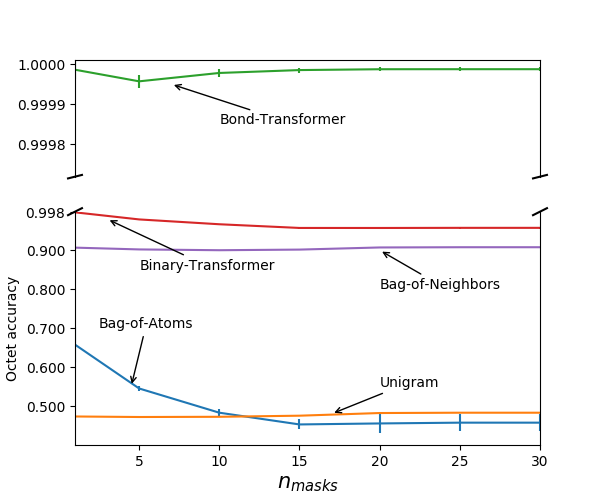

In [41]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet accuracy')



colors = {'Unigram':'C1', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C4',
         'transformer':'C3',
         'transformer bond':'C2',
         'OctetRule':'C5',
         'Bag-of-atoms_old':'W',
         'Bag-of-neighbors_old':'W'}

for key, group in results_mask2['accuracy_octet'].reset_index().groupby('model_name_short'):
    if 'Octet' not in key and 'old' not in key:
        group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])
        if 'bond' not in key:
            group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.99972, 1.00001])
ax2.set_ylim([0.4, 0.999])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False, top=False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.998])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(4.5,0.55), xytext=(2.5,0.7),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(20,0.9), xytext=(20,0.80),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})

plt.savefig('images/octet_accuracy_vs_nmask_qm9.pgf', bbox_inches="tight")

<IPython.core.display.Javascript object>


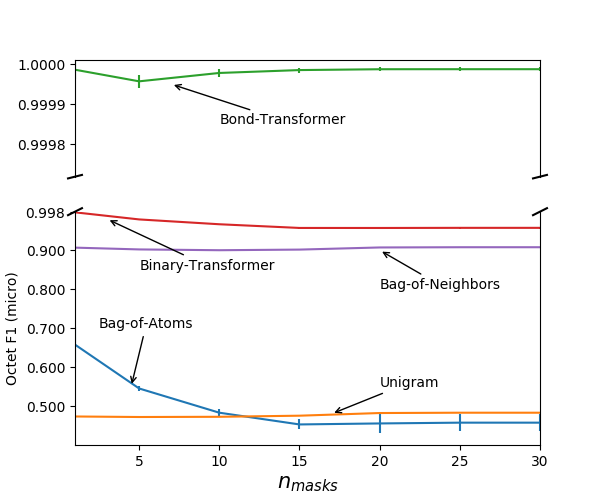

In [15]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (micro)')



colors = {'Unigram':'C1', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C4',
         'transformer':'C3',
         'transformer bond':'C2',
         'OctetRule':'C5',
         'Bag-of-atoms_old':'W',
         'Bag-of-neighbors_old':'W'}

for key, group in results_mask2['f1 micro (octet)'].reset_index().groupby('model_name_short'):
    if 'Octet' not in key and 'old' not in key:
        group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])
        if 'bond' not in key:
            group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.99972, 1.00001])
ax2.set_ylim([0.4, 0.999])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False, top=False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.998])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(4.5,0.55), xytext=(2.5,0.7),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(20,0.9), xytext=(20,0.80),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})

plt.savefig('images/octet_f1_micro_vs_nmask_qm9.pdf')

<IPython.core.display.Javascript object>


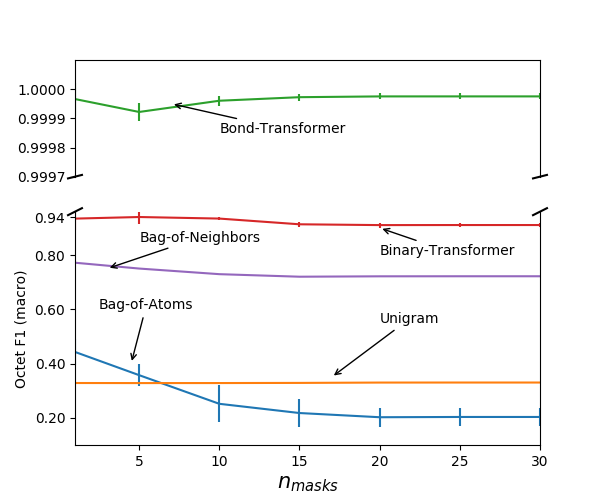

In [18]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (macro)')



colors = {'Unigram':'C1', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C4',
         'transformer':'C3',
         'transformer bond':'C2',
         'OctetRule':'C5',
         'Bag-of-atoms_old':'W',
         'Bag-of-neighbors_old':'W'}

for key, group in results_mask2['f1 macro (octet)'].reset_index().groupby('model_name_short'):
    if 'Octet' not in key and 'old' not in key:
        group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])
        if 'bond' not in key:
            group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.99972, 1.0001])
ax.set_yticks([0.9997,0.9998, 0.9999,1])
ax2.set_ylim([0.1, 0.96])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False, top=False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.2,0.4,0.6,0.8,0.94])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(17,0.35), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(4.5,0.4), xytext=(2.5,0.6),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(20,0.9), xytext=(20,0.80),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(3,0.75), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})

plt.savefig('images/octet_f1_macro_vs_nmask_qm9.pdf')

<IPython.core.display.Javascript object>


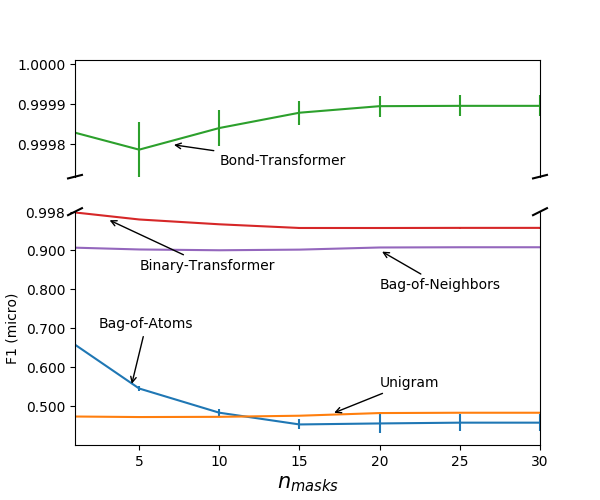

In [21]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('F1 (micro)')



colors = {'Unigram':'C1', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C4',
         'transformer':'C3',
         'transformer bond':'C2',
         'OctetRule':'C5',
         'Bag-of-atoms_old':'W',
         'Bag-of-neighbors_old':'W'}

for key, group in results_mask2['f1 micro'].reset_index().groupby('model_name_short'):
    if 'Octet' not in key and 'old' not in key:
        group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])
        if 'bond' not in key:
            group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.99972, 1.00001])
ax2.set_ylim([0.4, 0.999])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False, top=False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.998])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(4.5,0.55), xytext=(2.5,0.7),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(20,0.9), xytext=(20,0.80),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.9998), xytext=(10,0.99975),arrowprops={'arrowstyle':'->'})

plt.savefig('images/sample_f1_micro_vs_nmask_qm9.pdf')

<IPython.core.display.Javascript object>


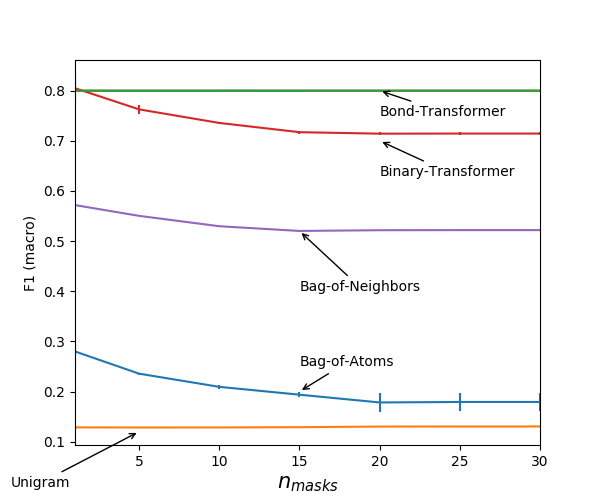

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
plt.ylabel('F1 (macro)')



for key, group in results_mask2['f1 macro'].reset_index().groupby('model_name_short'):
    if 'old' in key: continue
    #group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
#ax.set_ylim([0.97, 1.00001])
#ax.set_ylim([0.4, 1])


#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax.set_xticks([1,5,10,15,20,25,30,90])
#ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
#ax.get_legend().remove()
ax.get_legend().remove()
ax.set_xlabel('$n_{masks}$', fontsize=15)

ax.annotate('Unigram', xy=(5,0.12), xytext=(-3,0.01),arrowprops={'arrowstyle':'->',})
ax.annotate('Bag-of-Atoms', xy=(15,0.2), xytext=(15,0.25),arrowprops={'arrowstyle':'->'})
ax.annotate('Bag-of-Neighbors', xy=(15,0.52), xytext=(15,0.4),arrowprops={'arrowstyle':'->'})
ax.annotate('Binary-Transformer', xy=(20,0.7), xytext=(20,0.63),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(10,0.38), xytext=(10,0.3),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(20,0.8), xytext=(20,0.75),arrowprops={'arrowstyle':'->'})


plt.savefig('images/sample_f1_macro_vs_nmask_qm9.pdf')

In [33]:
results_length2 = results_length.groupby(['model_name_short', 'length']).agg(['mean','std'])
results_length2

f1 micro            f1 macro            \
                             mean       std      mean       std   
model_name_short length                                           
Bag-of-atoms     5       0.100000  0.253859  0.077778  0.166048   
                 6       0.280000  0.091894  0.217904  0.139404   
                 7       0.200000  0.000000  0.206111  0.061262   
                 8       0.205714  0.098791  0.192647  0.056957   
                 9       0.294286  0.073285  0.221541  0.055688   
...                           ...       ...       ...       ...   
transformer bond 22      1.000000  0.000000  1.000000  0.000000   
                 23      1.000000  0.000000  1.000000  0.000000   
                 24      1.000000  0.000000  1.000000  0.000000   
                 25      1.000000  0.000000  1.000000  0.000000   
                 27      1.000000  0.000000  1.000000  0.000000   

                        f1 micro (octet)           f1 macro (octet)            
                                    mean       std             mean       std  
model_name_short length                                                        
Bag-of-atoms     5              0.100000  0.253859         0.077778  0.166048  
                 6              0.290000  0.087560         0.232626  0.131833  
                 7              0.200000  0.000000         0.206111  0.061262  
                 8              0.211429  0.092533         0.196457  0.050397  
                 9              0.295238  0.072670         0.221913  0.055382  
...                                  ...       ...              ...       ...  
transformer bond 22             1.000000  0.000000         1.000000  0.000000  
                 23             1.000000  0.000000         1.000000  0.000000  
                 24             1.000000  0.000000         1.000000  0.000000  
                 25             1.000000  0.000000         1.000000  0.000000  
                 27             1.000000  0.000000         1.000000  0.000000  

[176 rows x 8 columns]

<IPython.core.display.Javascript object>


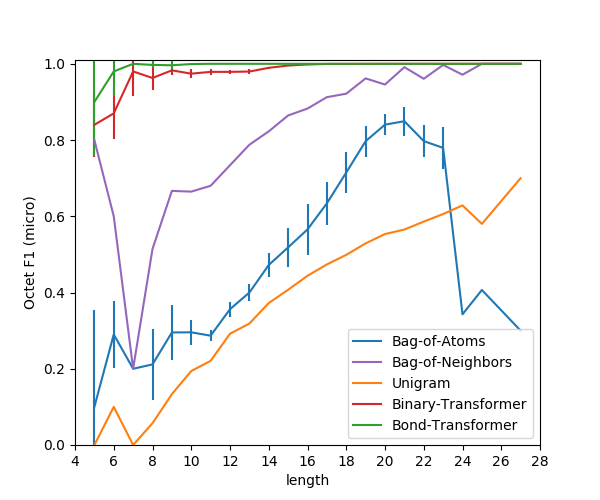

In [34]:

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('Octet F1 (micro)')
labels = {'Bag-of-atoms':'Bag-of-Atoms',
         'Bag-of-neighbors':'Bag-of-Neighbors',
         'Unigram':'Unigram',
         'transformer':'Binary-Transformer',
         'transformer bond':'Bond-Transformer'}
for key, group in results_length2['f1 micro (octet)'].reset_index().groupby('model_name_short'):
    if 'old' in key or 'Octet' in key: continue
    group.plot('length','mean',yerr='std', label=labels[key], ax=ax, color=colors[key])

ax.set_xticks(np.arange(4,30,2))    
ax.set_ylim([0,1.01])
plt.savefig('images/octet_f1_micro_vs_length_qm9.pdf')

<IPython.core.display.Javascript object>


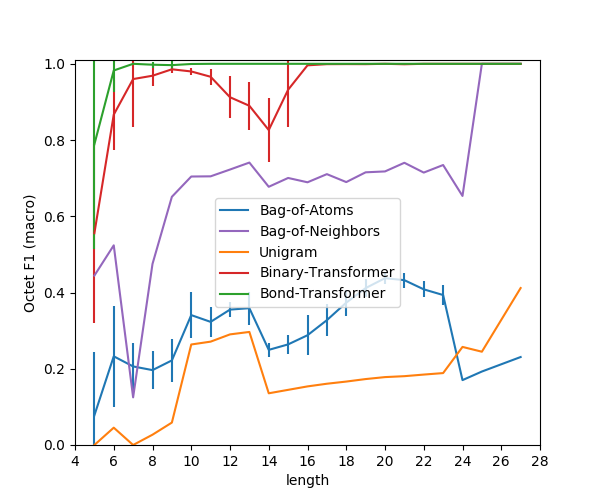

In [37]:

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('Octet F1 (macro)')

for key, group in results_length2['f1 macro (octet)'].reset_index().groupby('model_name_short'):
    if 'old' in key or 'Octet' in key: continue
    group.plot('length','mean',yerr='std', label=labels[key], ax=ax, color=colors[key])

ax.set_xticks(np.arange(4,30,2))    
ax.set_ylim([0,1.01])
plt.savefig('images/octet_f1_macro_vs_length_qm9.pdf')

<IPython.core.display.Javascript object>


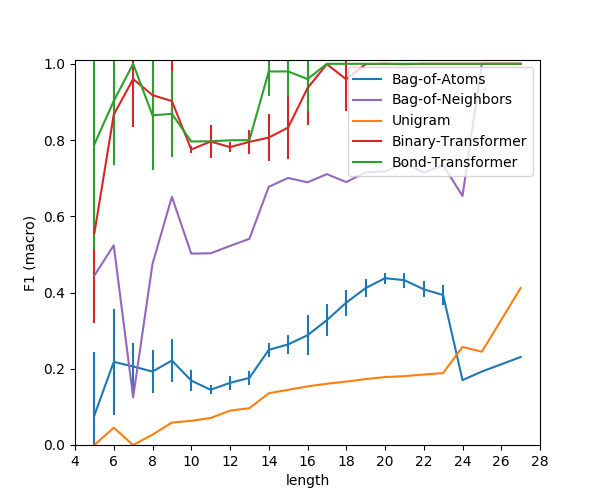

In [38]:

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('F1 (macro)')

for key, group in results_length2['f1 macro'].reset_index().groupby('model_name_short'):
    if 'old' in key or 'Octet' in key: continue
    group.plot('length','mean',yerr='std', label=labels[key], ax=ax, color=colors[key])

ax.set_xticks(np.arange(4,30,2))    
ax.set_ylim([0,1.01])
plt.savefig('images/sample_f1_macro_vs_length_qm9.pdf')

<IPython.core.display.Javascript object>


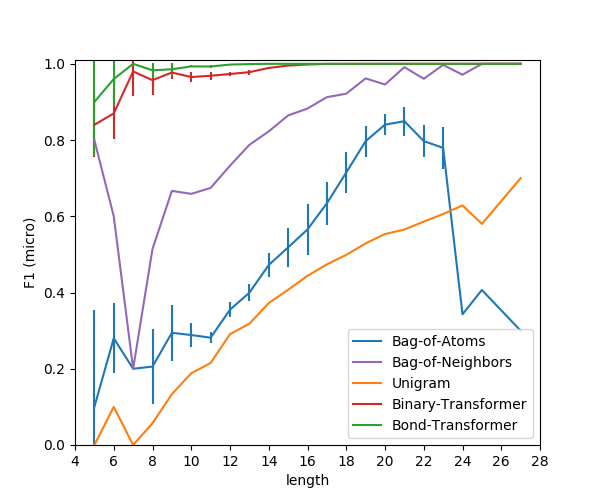

In [40]:

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('F1 (micro)')

for key, group in results_length2['f1 micro'].reset_index().groupby('model_name_short'):
    if 'old' in key or 'Octet' in key: continue
    group.plot('length','mean',yerr='std', label=labels[key], ax=ax, color=colors[key])

ax.set_xticks(np.arange(4,30,2))    
ax.set_ylim([0,1.01])
plt.savefig('images/sample_f1_micro_vs_length_qm9.pdf')